# Importing and reading csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, auc, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')
df=pd.read_csv("Fraud.csv")

# Basic EDA Practices

In [3]:
new_df = df.copy()
df_shape = df.shape
print("Number of rows:", df_shape[0])
print("Number of columns:", df_shape[1])
df.info()

Number of rows: 1000000
Number of columns: 32
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float

In [4]:
fraud_vals = pd.DataFrame(df['fraud_bool'].value_counts())
fraud_vals.reset_index(inplace=True)
fraud_vals.rename(columns={'index': 'fraud_bool', 'fraud_bool': 'count'}, inplace=True)

In [5]:
missing_vals = pd.DataFrame()
missing_features = ['prev_address_months_count', 'current_address_months_count', 'intended_balcon_amount', 'bank_months_count', 'session_length_in_minutes', 'device_distinct_emails_8w']
#replace -1 values with NaN, calculate the percentage of missing values, and add to the missing_vals DataFrame
for feature in missing_features:
    df.loc[df[feature] < 0, feature] = np.nan
    missing_vals_col = df.groupby('fraud_bool')[feature].apply(lambda x: round(x.isna().sum()/len(x) * 100, 2))
    missing_vals[feature] = missing_vals_col
# Reshape the missing_vals DataFrame from wide to long format
missing_vals = pd.DataFrame(missing_vals.T.stack())
missing_vals.reset_index(inplace=True)
missing_vals.rename(columns={'level_0': 'feature', 0: 'missing_vals'}, inplace=True)

# Feature Engg. (Encoding, Scaling)

In [6]:
#one hot encoding
categorical_features = [x for x in new_df.columns if new_df[x].dtypes == "O"]
new_df = pd.DataFrame(pd.get_dummies(new_df, prefix=categorical_features))
new_df.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,bank_branch_count_8w,date_of_birth_distinct_emails_4w,credit_risk_score,email_is_free,phone_home_valid,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,payment_type_AA,payment_type_AB,payment_type_AC,payment_type_AD,payment_type_AE,employment_status_CA,employment_status_CB,employment_status_CC,employment_status_CD,employment_status_CE,employment_status_CF,employment_status_CG,housing_status_BA,housing_status_BB,housing_status_BC,housing_status_BD,housing_status_BE,housing_status_BF,housing_status_BG,source_INTERNET,source_TELEAPP,device_os_linux,device_os_macintosh,device_os_other,device_os_windows,device_os_x11
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,1059,13096.035020,7850.955007,6742.080561,5,5,163,1,0,1,9,0,1500,0,16.224843,1,1,0,0,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,1658,9223.283431,5745.251481,5941.664859,3,18,154,1,1,1,2,0,1500,0,3.363854,1,1,0,0,False,False,False,True,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,1095,4471.472149,5471.988958,5992.555113,15,11,89,1,0,1,30,0,200,0,22.730559,0,1,0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,3483,14431.993620,6755.344479,5970.336831,11,13,90,1,0,1,1,0,200,0,15.215816,1,1,0,0,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,2339,7601.511579,5124.046930,5940.734212,1,6,91,0,1,1,26,0,200,0,3.743048,0,1,0,0,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False


In [7]:
# Separate the feature matrix and target variable
X = new_df.drop(['fraud_bool'], axis=1)
y = new_df['fraud_bool']

In [8]:
#Min-Max Scaling for Numerical Features
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]
numeric_transformer = MinMaxScaler()
preprocessor = ColumnTransformer([('scaled', numeric_transformer, numeric_features)], remainder='passthrough')
X_scaled = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
feature_names = [feature.replace('remainder__', '') for feature in feature_names]
print(feature_names)

['scaled__name_email_similarity', 'scaled__prev_address_months_count', 'scaled__current_address_months_count', 'scaled__days_since_request', 'scaled__intended_balcon_amount', 'scaled__zip_count_4w', 'scaled__velocity_6h', 'scaled__velocity_24h', 'scaled__velocity_4w', 'scaled__bank_branch_count_8w', 'scaled__date_of_birth_distinct_emails_4w', 'scaled__credit_risk_score', 'scaled__bank_months_count', 'scaled__proposed_credit_limit', 'scaled__session_length_in_minutes', 'income', 'customer_age', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'has_other_cards', 'foreign_request', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month', 'payment_type_AA', 'payment_type_AB', 'payment_type_AC', 'payment_type_AD', 'payment_type_AE', 'employment_status_CA', 'employment_status_CB', 'employment_status_CC', 'employment_status_CD', 'employment_status_CE', 'employment_status_CF', 'employment_status_CG', 'housing_status_BA', 'housing_status_BB', 'housing_status_B

In [9]:
# Convert the scaled training and testing sets to pandas DataFrames
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

# Feature Selection

In [10]:
%%time
# Perform NearMiss undersampling to handle imbalanced data
print(f'Test dataset samples per class {Counter(y)}')
nm = NearMiss(sampling_strategy=1, n_jobs=-1)
# Perform NearMiss undersampling on the feature matrix X and target variable y
X_scaled_nm, y_scaled_nm = nm.fit_resample(X_scaled, y)
print('Resampled dataset shape %s' % Counter(y_scaled_nm))

Test dataset samples per class Counter({0: 988971, 1: 11029})
Resampled dataset shape Counter({0: 11029, 1: 11029})
CPU times: total: 2min 55s
Wall time: 1min 8s


In [11]:
categorical_features = [feature for feature in X_scaled_nm.columns if X_scaled_nm[feature].nunique() >= 2 and X_scaled_nm[feature].nunique() < 10]
numeric_features = [feature for feature in X_scaled_nm.columns if X_scaled_nm[feature].nunique() >= 10]

In [12]:
# Instantiate a VarianceThreshold selector and fit it to the NearMiss-resampled training set
selector = VarianceThreshold()
selector.fit(X_scaled_nm)
constant_features = [feature for feature in X_scaled_nm.columns 
                     if feature not in X_scaled_nm.columns[selector.get_support()]]
print(constant_features)
X_scaled_nm.drop(['device_fraud_count'], axis=1, inplace=True)

['device_fraud_count']


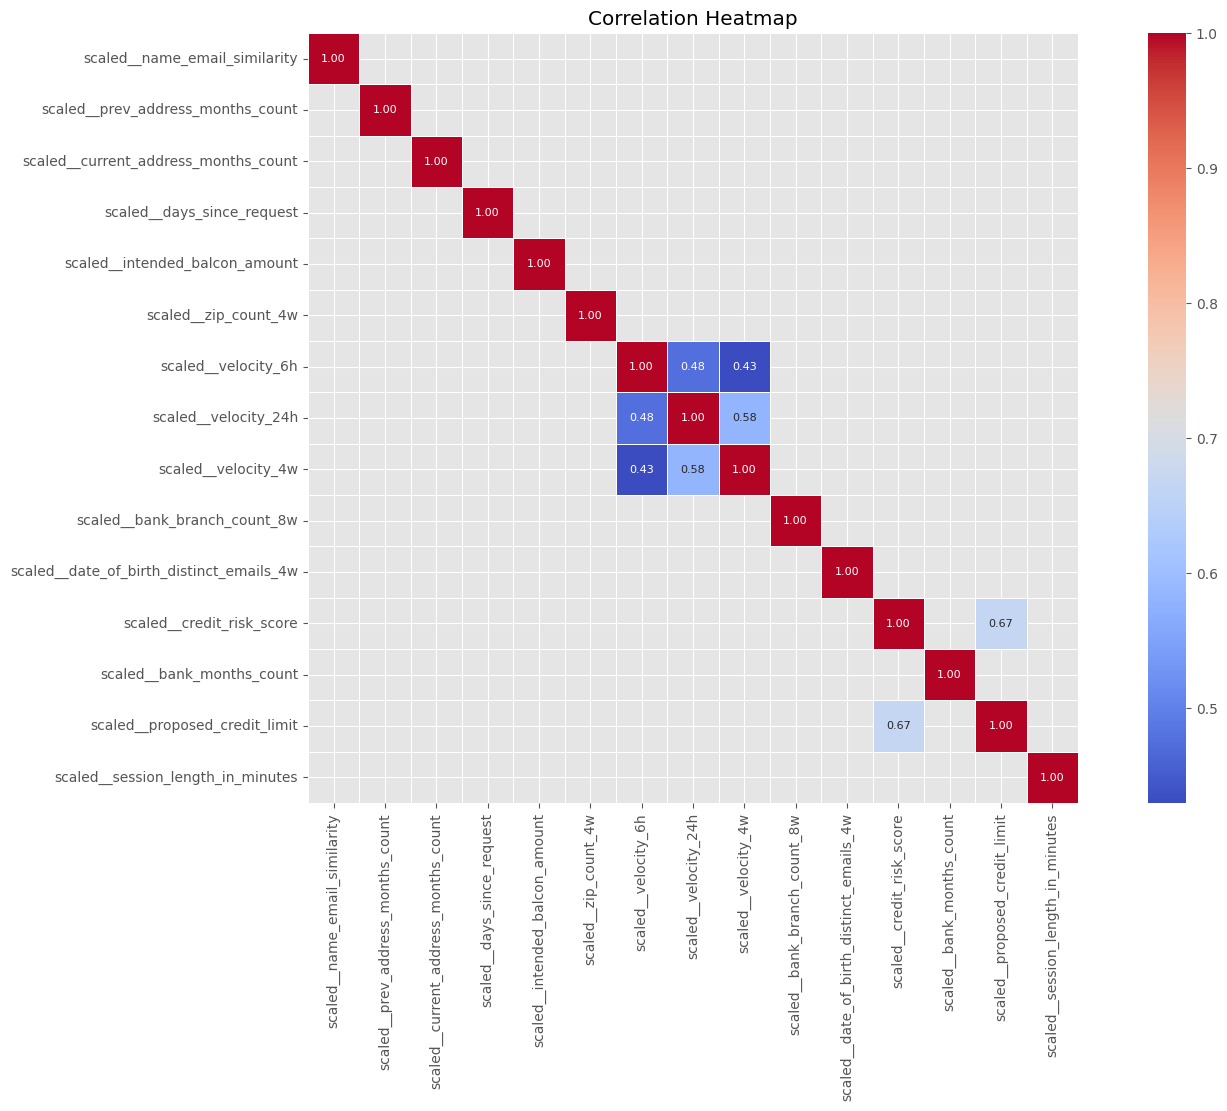

In [13]:
# Compute correlation matrix
X_train_corr = X_scaled_nm[numeric_features].corr()
# Plot correlation matrix with annotated values
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(X_train_corr[(X_train_corr >= 0.4) | (X_train_corr <= -0.4)], annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, square=True, ax=ax, annot_kws={"fontsize": 8})
plt.title('Correlation Heatmap')
plt.show()

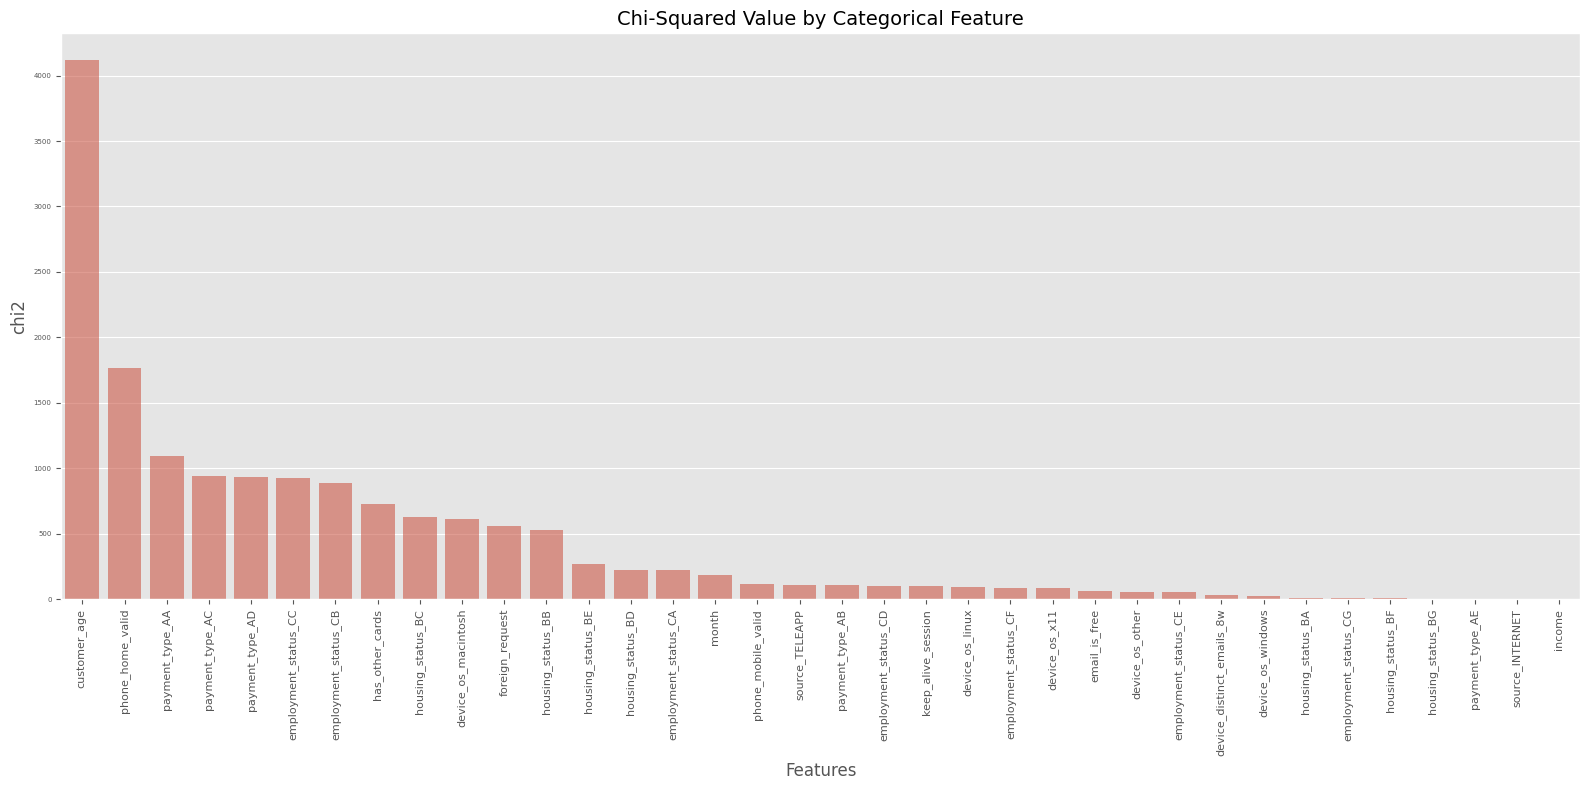

In [14]:
#chi square test
# Check the distribution of values in a column
X_scaled_nm.device_distinct_emails_8w.value_counts()
rows_to_drop = np.where(X_scaled_nm['device_distinct_emails_8w'] < 0)[0]
rows_to_drop
X_train_cat = X_scaled_nm[categorical_features].copy()
X_train_cat.drop(rows_to_drop, axis=0, inplace=True)

y_train_cat = y_scaled_nm.copy()
y_train_cat.drop(rows_to_drop, axis=0, inplace=True)
chi2_results = chi2(X_train_cat, y_train_cat)
chi2_results_df = pd.DataFrame(data={'feature': X_train_cat.columns, 'chi2': chi2_results[0], 'p_value': chi2_results[1]})
plt.figure(figsize=(16, 8))
sns.barplot(data=chi2_results_df.sort_values(by='chi2', ascending=False), x="feature", y="chi2", alpha=.6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("chi2", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=5)
plt.title("Chi-Squared Value by Categorical Feature", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
best_chi2_cols = SelectKBest(chi2, k=15)
best_chi2_cols.fit(X_train_cat, y_train_cat)
# Get the names of the top 5 features
best_chi2_features = [X_train_cat.columns[best_chi2_cols.get_support()]]
print(best_chi2_features)

[Index(['customer_age', 'phone_home_valid', 'has_other_cards',
       'foreign_request', 'payment_type_AA', 'payment_type_AC',
       'payment_type_AD', 'employment_status_CA', 'employment_status_CB',
       'employment_status_CC', 'housing_status_BB', 'housing_status_BC',
       'housing_status_BD', 'housing_status_BE', 'device_os_macintosh'],
      dtype='object')]


In [16]:
X_train_num = X_scaled_nm[numeric_features].copy()
y_train_num = y_scaled_nm.copy()
mutual_info_results = mutual_info_classif(X_train_num, y_train_num)
mutual_info_results_df = pd.DataFrame(data={'feature': X_train_num.columns, 'mutual_info': mutual_info_results})
best_mutual_info_cols = SelectKBest(mutual_info_classif, k=15)
best_mutual_info_cols.fit(X_train_num, y_train_num)
best_mutual_info_features = [X_train_num.columns[best_mutual_info_cols.get_support()]]
extra = ExtraTreesClassifier(n_estimators=50, random_state=0)
extra.fit(X_scaled_nm, y_scaled_nm)
# Create a SelectFromModel object with the fitted Random Forest model
feature_sel_extra = SelectFromModel(extra, prefit=True)
# Get the names of the selected features by calling .get_support() on the SelectFromModel object
best_extra_features = [X_scaled_nm.columns[(feature_sel_extra.get_support())]]
best_extra_features = list(best_extra_features[0])
extra_importances = pd.DataFrame({'feature': X_scaled_nm.columns, 'importance': extra.feature_importances_, 'model': 'ExtraTreesClassifier'})

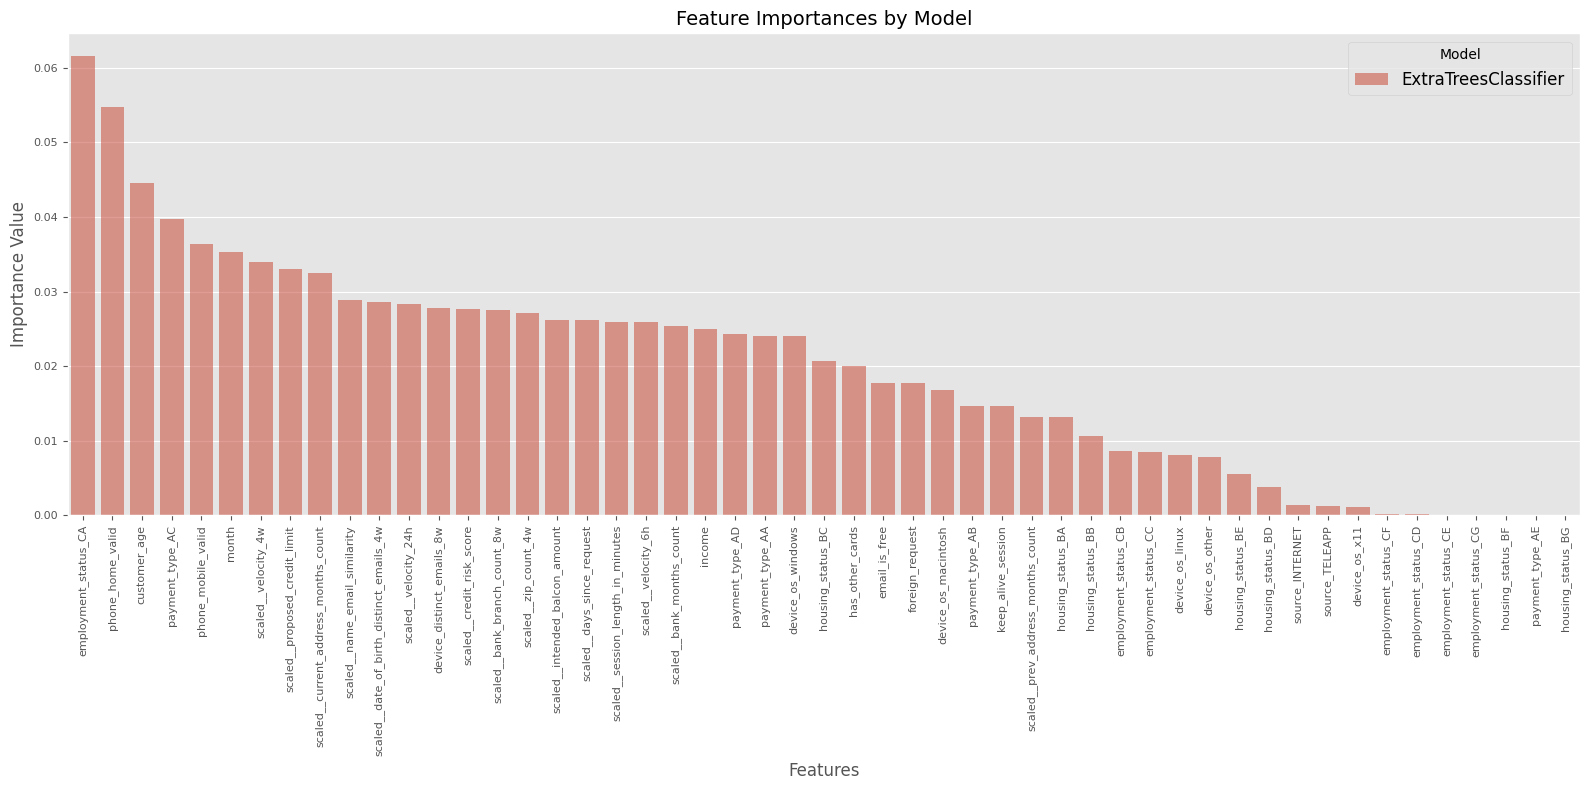

In [17]:
plt.figure(figsize=(16, 8))
sns.barplot(data=extra_importances.sort_values(by='importance', ascending=False), x="feature", y="importance", hue="model", alpha=.6)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance Value", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Feature Importances by Model", fontsize=14)
plt.legend(title='Model', fontsize=12)
plt.tight_layout()
plt.show()

# Fraud Detection Model Training Functions using SMOTE & Grid Search CV

In [18]:
def train_classifier(classifier, param_dist, X_train, y_train, encoded_features, search_type='random'):
    smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)   
    pipeline = make_pipeline(smote_nc, classifier)   
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)   
    if search_type == 'random':
        search_cv = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist,n_iter=20,scoring="roc_auc", n_jobs=-1,cv=cv)
    elif search_type == 'grid':
        search_cv = GridSearchCV(estimator=pipeline, param_grid=param_dist,scoring="roc_auc",n_jobs=-1, cv=cv)
    else:
        raise ValueError('search_type must be either "random" or "grid"')
    search_cv.fit(X_train, y_train)
    return search_cv
search_results = train_classifier(xgb, param_dist, X_train, y_train, encoded_features=[0, 1], search_type='random')
# Best parameters and score
print(search_results.best_params_)
print(search_results.best_score_)

NameError: name 'xgb' is not defined

# XGBoost

In [19]:
%%time
X = new_df.drop(['fraud_bool'], axis=1)
y = new_df['fraud_bool']
X.drop(['device_fraud_count'], axis=1, inplace=True)
print(f'Test dataset samples per class {Counter(y)}')
nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)
X_nm, y_nm = nm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_nm))

Test dataset samples per class Counter({0: 988971, 1: 11029})
Resampled dataset shape Counter({0: 110290, 1: 11029})
CPU times: total: 2min 50s
Wall time: 1min 4s


In [20]:
# Instantiate a XGBClassifier model with GPU acceleration for training
xgb = XGBClassifier(tree_method='gpu_hist')
X_train, X_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.25, random_state=42, stratify=y_nm)
encoded_features = [X_train.columns.get_loc(str(feature)) for feature in X_train.columns if X_train[feature].nunique() >= 2 and X_train[feature].nunique() < 10]
# Define a dictionary of hyperparameters for XGBClassifier
xgb_params = {'xgbclassifier__n_estimators': [20, 40, 60, 80, 100],
              'xgbclassifier__max_depth': [2, 4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4],
              'xgbclassifier__subsample': [0.6, 0.8, 1.0],
              'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0]}

In [ ]:
xgb_model = train_classifier(xgb, xgb_params, X_train, y_train, encoded_features)
print_cv_results(xgb_model)

C:\Users\mainak ghosh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Default Threshold
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.97      0.98      0.97     27573
       Fraud       0.73      0.67      0.70      2757

    accuracy                           0.95     30330
   macro avg       0.85      0.82      0.83     30330
weighted avg       0.95      0.95      0.95     30330

Target Threshold @ 0.28
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.98      0.95      0.96     27573
       Fraud       0.61      0.77      0.68      2757

    accuracy                           0.93     30330
   macro avg       0.79      0.86      0.82     30330
weighted avg       0.94      0.93      0.94     30330



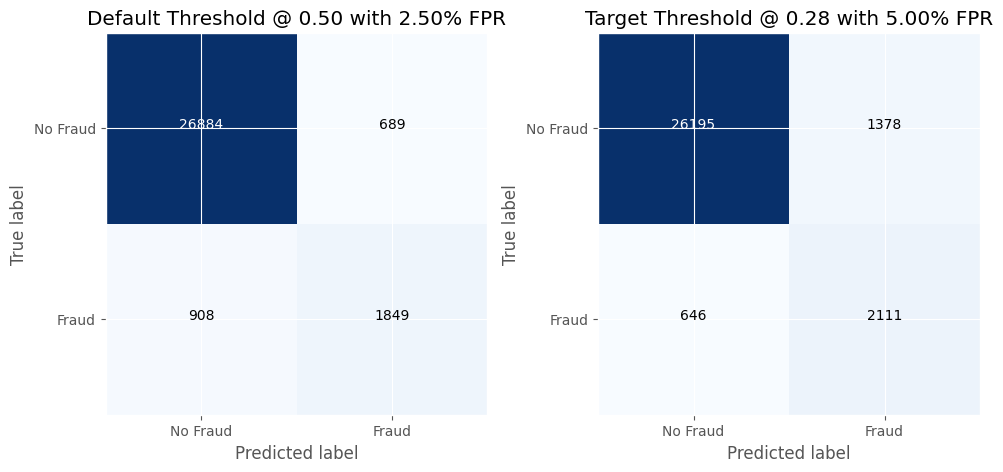

In [45]:
xgb_fpr, xgb_tpr, xgb_default_recall, xgb_target_recall = test_classifier(xgb_model, X_test, y_test)

In [46]:
%%time
smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)
print(f'Train dataset samples per class {Counter(y_train)}')
sm = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_sm))

Train dataset samples per class Counter({0: 82717, 1: 8272})
Resampled dataset shape Counter({0: 82717, 1: 82717})
CPU times: total: 36.6 s
Wall time: 40.3 s


Default Threshold
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.97      0.98      0.97     27573
       Fraud       0.75      0.66      0.70      2757

    accuracy                           0.95     30330
   macro avg       0.86      0.82      0.84     30330
weighted avg       0.95      0.95      0.95     30330

Target Threshold @ 0.24
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.98      0.95      0.96     27573
       Fraud       0.61      0.77      0.68      2757

    accuracy                           0.93     30330
   macro avg       0.79      0.86      0.82     30330
weighted avg       0.94      0.93      0.94     30330



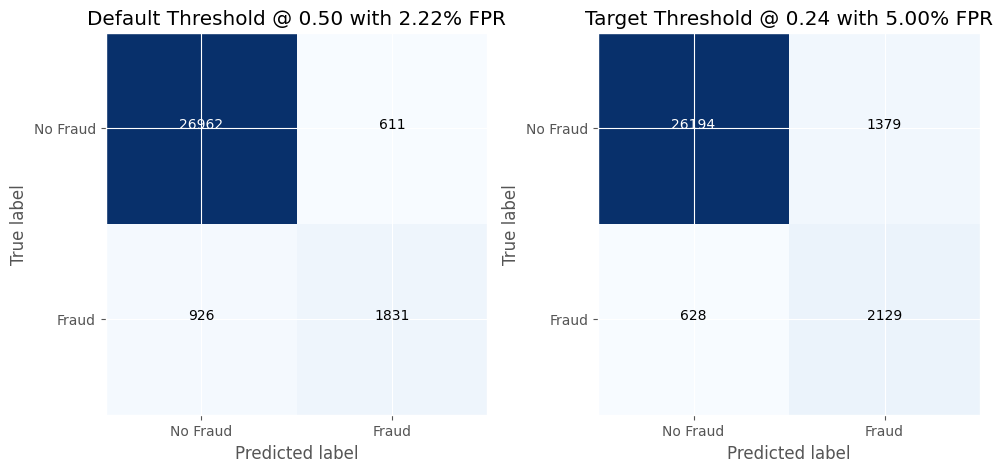

In [47]:
xgb_final = XGBClassifier(n_estimators = 100, max_depth = 10, learning_rate = 0.15, min_child_weight = 2, subsample = 0.6, colsample_bytree = 0.8)
xgb_final.fit(X_sm, y_sm)
xgb_final_fpr, xgb_final_tpr, xgb_final_default_recall, xgb_final_target_recall = test_classifier(xgb_final, X_test, y_test)

ROC-AUC Score: 0.95


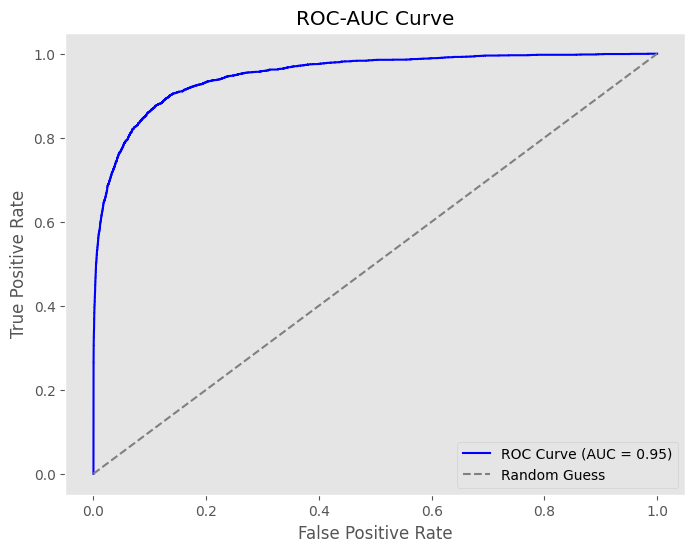

In [36]:
y_pred_proba = xgb_final.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()